In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.constants import k as k_B
from scipy.constants import N_A
import seaborn as sns
import glob
import plumed
import re

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from md_styler import MDStyler
styler = MDStyler().apply()

In [24]:
def compute_potential(CV, weights):
    hist, bins = np.histogram(CV, bins=400, weights=weights, range=(0,4))
    min_nonzero = np.min(hist[hist > 0])
    hist[hist == 0] = min_nonzero * 0.01  
    
    centers = (bins[:-1] + bins[1:]) / 2
    index1 = np.argmin(np.abs(centers - 1.8))
    index2 = np.argmin(np.abs(centers - 2))
    V = -k_B * 300 * np.log(hist)*N_A / 1000
    V -= np.mean(V[index1:index2])
    return centers, V

In [25]:
from scipy.signal import savgol_filter
from scipy import stats
def smooth_savgol(y, window=15, polyorder=3):
    """Apply Savitzky-Golay smoothing"""
    window = max(5, window)
    if window % 2 == 0:
        window += 1
    window = min(window, len(y) - 1)
    polyorder = min(polyorder, window - 1)
    
    mask = np.isfinite(y)
    if not np.all(mask):
        y_clean = y[mask]
        y_smooth = savgol_filter(y_clean, window, polyorder)
        y_out = np.full_like(y, np.nan)
        y_out[mask] = y_smooth
        return y_out
    
    return savgol_filter(y, window, polyorder)

In [26]:
def block_analysis_minimal(df, n_blocks=5, x_min=0.0, use_sem=False, confidence=0.95):
    """
    Minimal block analysis for error estimation
    
    Parameters:
    -----------
    df : DataFrame with 'dist' and 'weight' columns
    n_blocks : int
    x_min : float
        Only use data where dist > x_min for error calculation
    use_sem : bool
        If True, return standard error of mean (SEM) instead of std
    confidence : float
        Confidence level for SEM (e.g., 0.95 for 95% CI)
    
    Returns:
    --------
    mean_error : float
        Mean standard deviation (or SEM) in the region dist > x_min
    """
    n_frames = len(df)
    block_size = n_frames // n_blocks
    
    V_blocks = []
    
    for i in range(n_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < n_blocks - 1 else n_frames
        
        df_block = df.iloc[start:end]
        centers, V = compute_potential(df_block.dist.values, df_block.weight.values)
        V_blocks.append(V)
    
    V_blocks = np.array(V_blocks)
    
    if use_sem:
        V_std = np.std(V_blocks, axis=0, ddof=1)
        V_sem = V_std / np.sqrt(n_blocks)
        alpha = 1 - confidence
        t_val = stats.t.ppf(1 - alpha/2, n_blocks - 1)
        V_error = t_val * V_sem
    else:
        V_error = np.std(V_blocks, axis=0, ddof=1)
    
    mask = centers > x_min
    mean_error = np.mean(V_error[mask])
    
    return mean_error


def compute_minimum_statistics(V_blocks, centers, smooth=True, window=15, polyorder=3,
                               use_sem=True, confidence=0.95, search_range=(0.4, 1.5)):
    """
    Compute statistics for minimum location and energy
    
    Parameters:
    -----------
    V_blocks : array (n_blocks, n_bins)
        Free energy from each block
    centers : array
        Distance values
    smooth : bool
    window, polyorder : int
        Smoothing parameters
    use_sem : bool
    confidence : float
    search_range : tuple
        Range to search for minimum (r_min, r_max)
    
    Returns:
    --------
    stats_dict : dict
        Contains mean, std/CI for r_min and V_min
    """
    n_blocks = V_blocks.shape[0]
    
    r_mins = []
    V_mins = []
    
    # Find minimum for each block
    mask = (centers >= search_range[0]) & (centers <= search_range[1])
    
    for V in V_blocks:
        if smooth:
            V_smooth = smooth_savgol(V, window, polyorder)
        else:
            V_smooth = V
        
        min_idx = np.argmin(V_smooth[mask])
        r_min = centers[mask][min_idx]
        V_min = V_smooth[mask][min_idx]
        
        r_mins.append(r_min)
        V_mins.append(V_min)
    
    r_mins = np.array(r_mins)
    V_mins = np.array(V_mins)
    
    # Calculate statistics
    r_min_mean = np.mean(r_mins)
    V_min_mean = np.mean(V_mins)
    
    if use_sem:
        r_min_std = np.std(r_mins, ddof=1)
        V_min_std = np.std(V_mins, ddof=1)
        
        r_min_sem = r_min_std / np.sqrt(n_blocks)
        V_min_sem = V_min_std / np.sqrt(n_blocks)
        
        alpha = 1 - confidence
        t_val = stats.t.ppf(1 - alpha/2, n_blocks - 1)
        
        r_min_error = t_val * r_min_sem
        V_min_error = t_val * V_min_sem
        error_type = f'{int(confidence*100)}% CI'
    else:
        r_min_error = np.std(r_mins, ddof=1)
        V_min_error = np.std(V_mins, ddof=1)
        error_type = 'SD'
    
    return {
        'r_min_mean': r_min_mean,
        'r_min_error': r_min_error,
        'r_min_values': r_mins,
        'V_min_mean': V_min_mean,
        'V_min_error': V_min_error,
        'V_min_values': V_mins,
        'error_type': error_type,
        'n_blocks': n_blocks
    }


def plot_potential(df, axs, smooth=True, window=15, polyorder=3,
                   plot_error=False, n_blocks=5, error_x_min=0.6,
                   use_sem=True, confidence=0.95,
                   plot_convergence=False, show_raw=False, **plotkwargs):
    """
    Plot potential of mean force with optional error bars
    
    Parameters:
    -----------
    df : DataFrame with 'dist' and 'weight' columns
    axs : matplotlib axis
    smooth : bool (default True)
    window : int (default 15)
    polyorder : int (default 3)
    plot_error : bool
    n_blocks : int
    error_x_min : float - only calculate/plot errors for r > error_x_min
    use_sem : bool - use standard error instead of std (default True)
    confidence : float - confidence level for SEM (default 0.95)
    plot_convergence : bool
    show_raw : bool
    **plotkwargs : passed to plot
    
    Returns:
    --------
    axs : matplotlib axis
    centers : array
    V_smooth : array
    V_error_smooth : array or None
    min_stats : dict or None
        Statistics for minimum (if plot_error=True)
    """
    CVs = df.dist.values
    weights = df.weight.values
    
    # Plot convergence
    if plot_convergence:
        color = plotkwargs.get('color', 'C0')
        for i in range(df.shape[0] // 10, df.shape[0] + 1, df.shape[0] // 10):
            centers, V = compute_potential(CVs[:i], weights[:i])
            V_plot = smooth_savgol(V, window, polyorder) if smooth else V
            axs.plot(centers, V_plot, color=color, ls='--', alpha=0.3, linewidth=1)
    
    # Block analysis for errors
    if plot_error:
        n_frames = len(df)
        block_size = n_frames // n_blocks
        V_blocks = []
        
        for i in range(n_blocks):
            start = i * block_size
            end = (i + 1) * block_size if i < n_blocks - 1 else n_frames
            df_block = df.iloc[start:end]
            centers, V = compute_potential(df_block.dist.values, df_block.weight.values)
            V_blocks.append(V)
        
        V_blocks = np.array(V_blocks)
        V = np.mean(V_blocks, axis=0)
        
        if use_sem:
            V_std = np.std(V_blocks, axis=0, ddof=1)
            V_sem = V_std / np.sqrt(n_blocks)
            
            alpha = 1 - confidence
            t_val = stats.t.ppf(1 - alpha/2, n_blocks - 1)
            V_error = t_val * V_sem
            
            error_type = f'{int(confidence*100)}% CI'
        else:
            V_error = np.std(V_blocks, axis=0, ddof=1)
            error_type = 'SD'
        
        # Compute minimum statistics
        min_stats = compute_minimum_statistics(V_blocks, centers, smooth, window, polyorder,
                                               use_sem, confidence)
        
        # Print error only for r > error_x_min
        mask = centers > error_x_min
        label = plotkwargs.get('label', 'Unknown')
        print(f'{label} - {n_blocks} blocks (r > {error_x_min} nm):')
        print(f'  Mean {error_type}: {np.mean(V_error[mask]):.2f} kJ/mol')
        print(f'  r_min: {min_stats["r_min_mean"]:.3f} ± {min_stats["r_min_error"]:.3f} nm')
        print(f'  V_min: {min_stats["V_min_mean"]:.2f} ± {min_stats["V_min_error"]:.2f} kJ/mol')
        if use_sem:
            print(f'  t-value: {t_val:.3f}')
    else:
        centers, V = compute_potential(CVs, weights)
        V_error = None
        min_stats = None
    
    # Smooth
    if smooth:
        V_smooth = smooth_savgol(V, window, polyorder)
        if V_error is not None:
            V_error_smooth = smooth_savgol(V_error, window, polyorder)
        else:
            V_error_smooth = None
        
        if show_raw:
            axs.plot(centers, V, alpha=0.3, linewidth=1, 
                    color=plotkwargs.get('color', 'C0'))
        
        axs.plot(centers, V_smooth, **plotkwargs)
    else:
        V_smooth = V
        V_error_smooth = V_error
        axs.plot(centers, V, **plotkwargs)
    
    # Plot error bands only for r > error_x_min
    if plot_error and V_error_smooth is not None:
        color = plotkwargs.get('color', 'C0')
        mask = centers > error_x_min
        axs.fill_between(centers[mask], 
                        V_smooth[mask] - V_error_smooth[mask], 
                        V_smooth[mask] + V_error_smooth[mask],
                        alpha=0.2, color=color)
    
    # Styling
    axs.set_xlabel('COM-COM Distance (nm)', fontsize=12)
    axs.set_ylabel('Free Energy (kJ/mol)', fontsize=12)
    axs.set_xlim(0.4, 2.5)
    axs.set_ylim(-15, 20)
    axs.grid(True, alpha=0.3, linewidth=0.5)
    
    # Print simple stats (from mean curve)
    if not plot_error:
        label = plotkwargs.get('label', 'Unknown')
        min_idx = np.argmin(V_smooth)
        print(f'{label} minimal distance: {centers[min_idx]:.3f} nm')
        print(f'{label} minimal potential: {V_smooth[min_idx]:.2f} kJ/mol')
    
    return axs, centers, V_smooth, V_error_smooth, min_stats


def scan_blocks(df, block_range=range(3, 21), x_min=0.6, 
                use_sem=True, confidence=0.95, plot=False):
    """
    Scan different block numbers and return mean errors
    
    Parameters:
    -----------
    df : DataFrame
    block_range : range or list
    x_min : float
    use_sem : bool
    confidence : float
    plot : bool
    
    Returns:
    --------
    errors : list
    """
    errors = []
    
    for n_blocks in block_range:
        error = block_analysis_minimal(df, n_blocks, x_min, use_sem, confidence)
        errors.append(error)
    
    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(list(block_range), errors, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Number of Blocks', fontsize=12)
        
        if use_sem:
            ylabel = f'Mean {int(confidence*100)}% CI (kJ/mol) for r > {x_min} nm'
        else:
            ylabel = f'Mean SD (kJ/mol) for r > {x_min} nm'
        ax.set_ylabel(ylabel, fontsize=12)
        
        ax.grid(True, alpha=0.3)
        ax.set_title(f'Error vs Block Number (r > {x_min} nm)', 
                    fontsize=13, fontweight='bold')
        
        # Find plateau
        errors_arr = np.array(errors)
        if len(errors_arr) > 1:
            rel_change = np.abs(np.diff(errors_arr)) / (errors_arr[:-1] + 1e-10)
            stable = np.where(rel_change < 0.05)[0]
            if len(stable) > 0:
                n_optimal = list(block_range)[stable[0]]
                ax.axvline(n_optimal, color='red', ls='--', linewidth=2,
                          label=f'Converged at {n_optimal}')
                ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    return errors


In [27]:
filenms = sorted(glob.glob('../metad/COLVARS*/*.weight'))
print(filenms)
x = filenms[0]
print(x)
df = pd.read_csv(x, sep=' ', header=None, names=['dist', 'weight'])


['../metad/COLVARS_AR-AR/dist-AR-AR.weight', '../metad/COLVARS_AR-AS/dist-AR-AS.weight', '../metad/COLVARS_AR-BR/dist-AR-BR.weight', '../metad/COLVARS_AR-BS/dist-AR-BS.weight', '../metad/COLVARS_BR-BR/dist-BR-BR.weight', '../metad/COLVARS_BR-BS/dist-BR-BS.weight', '../metad/COLVARS_CG_AR-AR/dist-CG_AR-AR.weight', '../metad/COLVARS_CG_AR-ARv2/dist-CG_AR-ARv2.weight', '../metad/COLVARS_CG_AR-ARv3/dist-CG_AR-ARv3.weight', '../metad/COLVARS_CG_AR-AS/dist-CG_AR-AS.weight', '../metad/COLVARS_CG_AR-ASv2/dist-CG_AR-ASv2.weight', '../metad/COLVARS_CG_AR-BR/dist-CG_AR-BR.weight', '../metad/COLVARS_CG_AR-BRv2/dist-CG_AR-BRv2.weight', '../metad/COLVARS_CG_BR-BR/dist-CG_BR-BR.weight', '../metad/COLVARS_CG_BR-BRv2/dist-CG_BR-BRv2.weight', '../metad/COLVARS_CG_BR-BS/dist-CG_BR-BS.weight', '../metad/COLVARS_CG_BR-BSv2/dist-CG_BR-BSv2.weight']
../metad/COLVARS_AR-AR/dist-AR-AR.weight


AA AR-AR - 8 blocks (r > 0 nm):
  Mean 95% CI: 2.84 kJ/mol
  r_min: 0.664 ± 0.018 nm
  V_min: -10.16 ± 0.36 kJ/mol
  t-value: 2.365
AA BR-BR - 8 blocks (r > 0 nm):
  Mean 95% CI: 2.28 kJ/mol
  r_min: 0.621 ± 0.025 nm
  V_min: -12.28 ± 0.55 kJ/mol
  t-value: 2.365
AA AR-AS - 8 blocks (r > 0 nm):
  Mean 95% CI: 2.34 kJ/mol
  r_min: 0.665 ± 0.028 nm
  V_min: -9.27 ± 0.88 kJ/mol
  t-value: 2.365
AA BR-BS - 8 blocks (r > 0 nm):
  Mean 95% CI: 1.90 kJ/mol
  r_min: 0.617 ± 0.028 nm
  V_min: -11.13 ± 0.76 kJ/mol
  t-value: 2.365
AA AR-BR - 8 blocks (r > 0 nm):
  Mean 95% CI: 2.31 kJ/mol
  r_min: 0.650 ± 0.010 nm
  V_min: -10.66 ± 0.30 kJ/mol
  t-value: 2.365
AA AR-BS - 8 blocks (r > 0 nm):
  Mean 95% CI: 2.37 kJ/mol
  r_min: 0.656 ± 0.034 nm
  V_min: -9.32 ± 0.81 kJ/mol
  t-value: 2.365


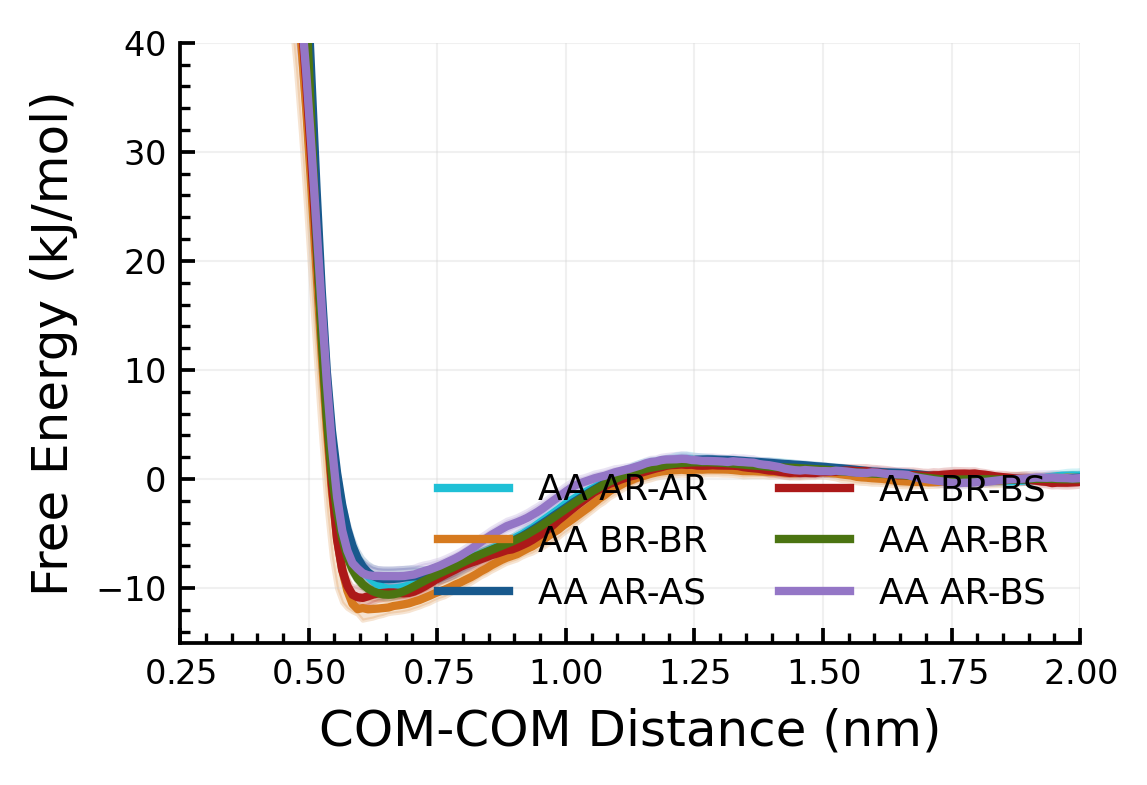

AA AR-AR minimal distance: 0.655 nm
AA AR-AR minimal potential: -10.07 kJ/mol
(50001, 2)
CG AR-AR minimal distance: 0.595 nm
CG AR-AR minimal potential: -7.95 kJ/mol
AA AR-AS minimal distance: 0.655 nm
AA AR-AS minimal potential: -9.31 kJ/mol
(50001, 2)
CG AR-AS minimal distance: 0.625 nm
CG AR-AS minimal potential: -6.84 kJ/mol


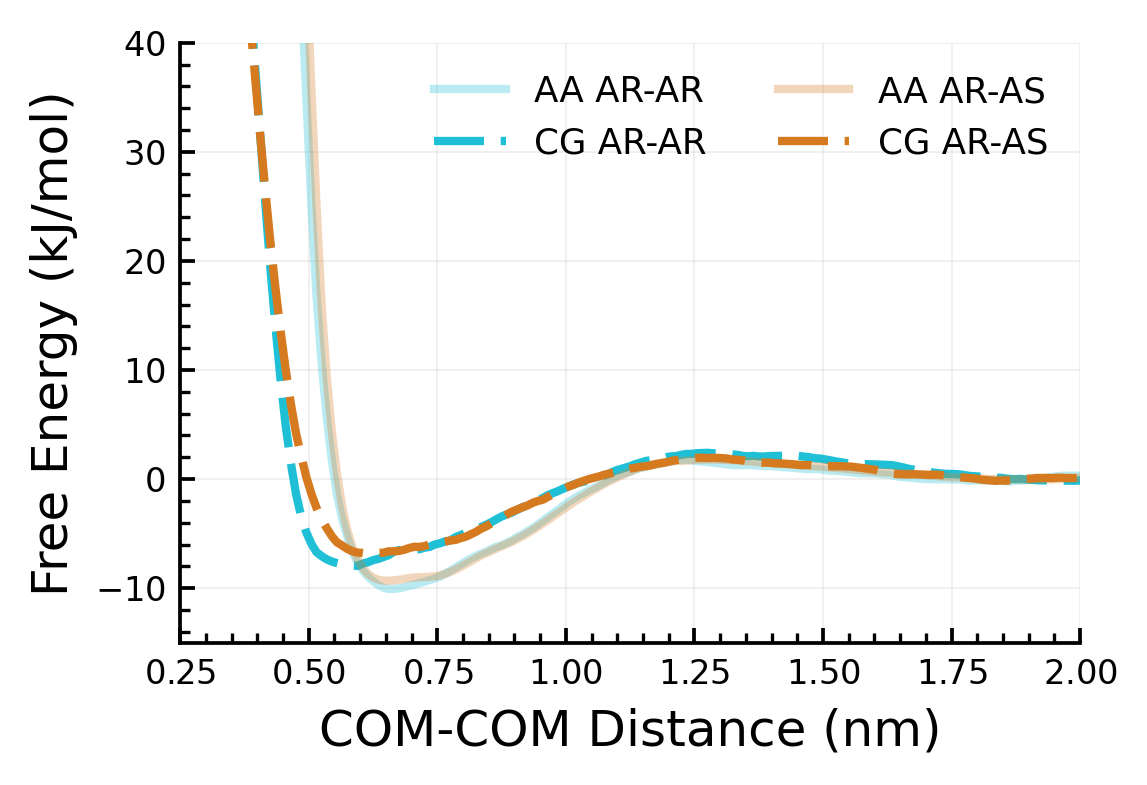

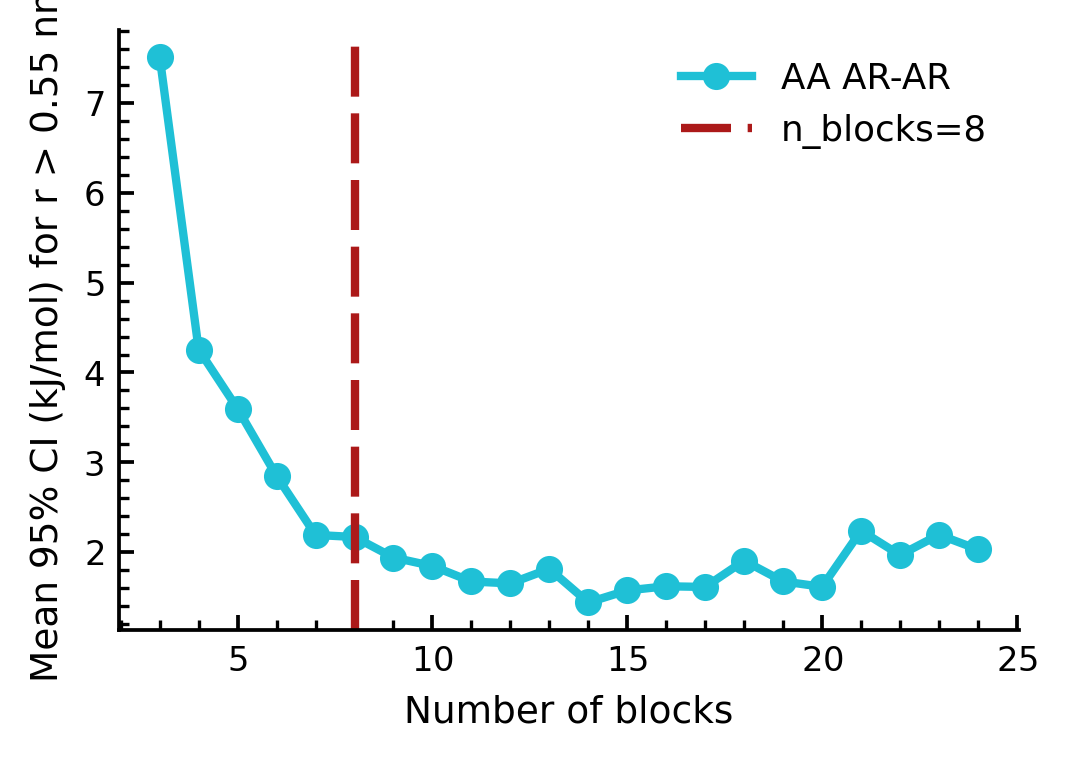

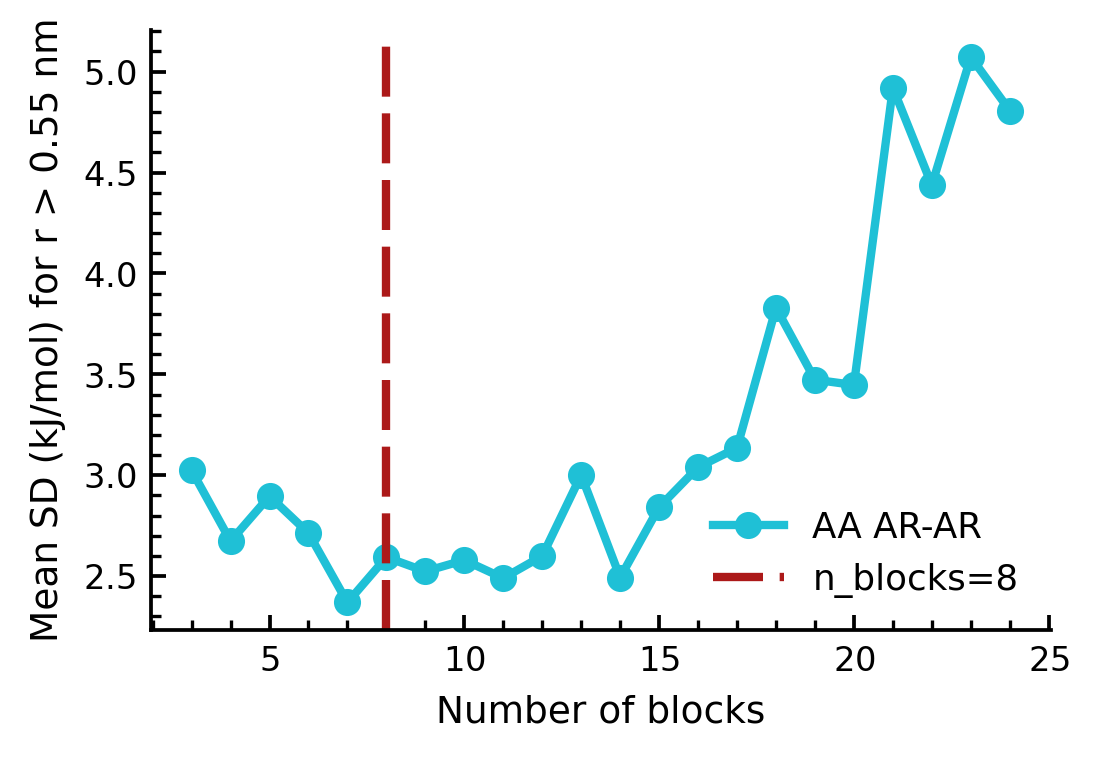

In [31]:
all_keys = ["AR-AR", "BR-BR", "AR-AS", "BR-BS", "AR-BR", "AR-BS"]
comparison_keys = ["AR-AR", "AR-AS"]
metad_root = "../metad"
XLIM= [0.25, 2] # [0.5, 1] #
YLIM =  [-15, 40] # [-15, -5] #
LEGEND = True
N_BLOCKS = 8
CONF = 0.95
XMIN_ERR = 0.55                 # only show error for r > XMIN_ERR (exploding errors below)
BLOCK_RANGE = range(3, 25)    
APPENDIX_KEY = comparison_keys[0]  

def aa_path(key: str) -> str:
    return os.path.join(metad_root, f"COLVARS_{key}", f"dist-{key}.weight")

def cg1_path(key: str) -> str:
    return os.path.join(metad_root, f"COLVARS_CG_{key}", f"dist-CG_{key}.weight")

def read_weight_file(path: str) -> pd.DataFrame:
    return pd.read_csv(path, sep=r"\s+", header=None, names=["dist", "weight"])

palette = styler.get_palette(len(all_keys))
all_stats = {}
# ========== FIGURE 1: AA only (with 95% CI from block analysis, n=8) ==========
fig1, ax1 = styler.fig_horizontal()
for i, key in enumerate(all_keys):
    p = aa_path(key)
    if not os.path.exists(p):
        print(f"[skip] AA file missing for {key}: {p}")
        continue

    df_aa = read_weight_file(p)
    # plot + CI band and compute min stats
    _, centers, V_s, Verr_s, stats_aa = plot_potential(
        df_aa, ax1,
        plot_error=True, n_blocks=N_BLOCKS, error_x_min=0,
        use_sem=True, confidence=CONF,
        label=f"AA {key}", color=palette[i], **styler.as_aa()
    )
    all_stats[key] = stats_aa

if LEGEND:
    ax1.legend(frameon=False, ncol=2, loc='lower right')
ax1.set_xlim(XLIM)
ax1.set_ylim(YLIM)
styler.save(fig1, f"../figures/pmf_AA_ci{int(CONF*100)}_n{N_BLOCKS}.png")
plt.show()
# ========== FIGURE 2: AA vs CG1 (95% CI, print pairwise min stats) ==========
fig2, ax2 = styler.fig_horizontal()

for i, key in enumerate(comparison_keys):
    aa_p = aa_path(key)
    cg_p = cg1_path(key)
    if not (os.path.exists(aa_p) and os.path.exists(cg_p)):
        print(f"[skip] missing AA/CG1 for {key}: {aa_p} | {cg_p}")
        continue

    color = palette[i]

    # --- AA
    df_aa = read_weight_file(aa_p)
    _, _, _, _, stats_aa = plot_potential(
        df_aa, ax2,
        plot_error=False,
        label=f"AA {key}", color=color, alpha=0.3, **styler.as_aa()
    )

    # --- CG1 (dashed)
    df_cg = read_weight_file(cg_p)
    print(df_cg.shape)
    _, _, _, _, stats_cg = plot_potential(
        df_cg, ax2,
        plot_error=False,
        label=f"CG {key}", color=color, **styler.as_cg()
    )

    # --- Print paired 95% CI for minima
    if stats_aa and stats_cg:
        print(f"\n[{key}]  {N_BLOCKS} blocks, {int(CONF*100)}% CI")
        print(f"  AA: r_min = {stats_aa['r_min_mean']:.3f} ± {stats_aa['r_min_error']:.3f} nm;"
              f"  V_min = {stats_aa['V_min_mean']:.2f} ± {stats_aa['V_min_error']:.2f} kJ/mol")
        print(f"  CG: r_min = {stats_cg['r_min_mean']:.3f} ± {stats_cg['r_min_error']:.3f} nm;"
              f"  V_min = {stats_cg['V_min_mean']:.2f} ± {stats_cg['V_min_error']:.2f} kJ/mol")

ax2.legend(frameon=False, ncol=2, loc='upper right')
ax2.set_xlim(XLIM)
ax2.set_ylim(YLIM)
styler.save(fig2, f"../figures/pmf_AA_vs_CG1_ci{int(CONF*100)}_n{N_BLOCKS}.png")
plt.show()

# ========== APPENDIX: error vs number of blocks (for one representative key) ==========
# Uses your `scan_blocks` with use_sem True (CI) and False (SD)
aa_file = aa_path(APPENDIX_KEY)
df_app = read_weight_file(aa_file)

# --- 95% CI vs n_blocks
ci_errors = scan_blocks(df_app, block_range=BLOCK_RANGE, x_min=XMIN_ERR,
                        use_sem=True, confidence=CONF, plot=False)
fig_ci, ax_ci = styler.fig_horizontal()
xs = list(BLOCK_RANGE)
ax_ci.plot(xs, ci_errors, marker="o", label=f"AA {APPENDIX_KEY}")
ax_ci.axvline(N_BLOCKS, color=styler.get_color("red"), linestyle=styler.ls_cg,
                linewidth=2.0, label=f"n_blocks={N_BLOCKS}")
ax_ci.set_xlabel("Number of blocks")
ax_ci.set_ylabel(f"Mean {int(CONF*100)}% CI (kJ/mol) for r > {XMIN_ERR} nm")
ax_ci.legend(frameon=False)
styler.save(fig_ci, f"../figures/appendix_error_vs_blocks_CI_{APPENDIX_KEY}.png")
plt.show()
# --- SD vs n_blocks
sd_errors = scan_blocks(df_app, block_range=BLOCK_RANGE, x_min=XMIN_ERR,
                        use_sem=False, confidence=CONF, plot=False)
fig_sd, ax_sd = styler.fig_horizontal()
ax_sd.plot(xs, sd_errors, marker="o", label=f"AA {APPENDIX_KEY}")
ax_sd.axvline(N_BLOCKS, color=styler.get_color("red"), linestyle=styler.ls_cg,
                linewidth=2.0, label=f"n_blocks={N_BLOCKS}")
ax_sd.set_xlabel("Number of blocks")
ax_sd.set_ylabel(f"Mean SD (kJ/mol) for r > {XMIN_ERR} nm")
ax_sd.legend(frameon=False)
styler.save(fig_sd, f"../figures/appendix_error_vs_blocks_SD_{APPENDIX_KEY}.png")
plt.show()

In [22]:

t = 2.365
for c in ["r", "V"]:
    rA = np.mean([all_stats["AR-AR"][f"{c}_min_mean"], all_stats["AR-AS"][f"{c}_min_mean"]])
    rB = np.mean([all_stats["BR-BR"][f"{c}_min_mean"], all_stats["BR-BS"][f"{c}_min_mean"]])
    se_r = np.sqrt(np.sum([(all_stats[k][f"{c}_min_error"]/t)**2 for k in ["AR-AR","AR-AS","BR-BR","BR-BS"]]) / 4)
    dr, dr_err = rA - rB, se_r * t
    print(f"Δ{c} = {dr:.3f} ± {dr_err:.3f} nm (95% CI)")
    print(rA / rB)

Δr = 0.045 ± 0.025 nm (95% CI)
1.0726538849646823
ΔV = 1.992 ± 0.668 nm (95% CI)
0.8298721549418793


In [7]:
CVs = plumed.read_as_pandas('../metad/COLVARS_CG_AR-AR/HILLS')
print(CVs.shape)
CVs.head()

(50000, 5)


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/users_home/makke/miniconda3/envs/molecular-motor/lib/libplumedKernel.so" +++
/tmp/ipykernel_3570528/3303491950.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  CVs = plumed.read_as_pandas('../metad/COLVARS_CG_AR-AR/HILLS')


,time,dist,sigma_dist,height,biasf
0,9.999995,0.967364,0.05,0.222222,10
1,19.999990,0.763749,0.05,0.222222,10
2,29.999985,0.776197,0.05,0.220311,10
3,39.999980,0.589323,0.05,0.222218,10
4,49.999975,0.493505,0.05,0.221907,10


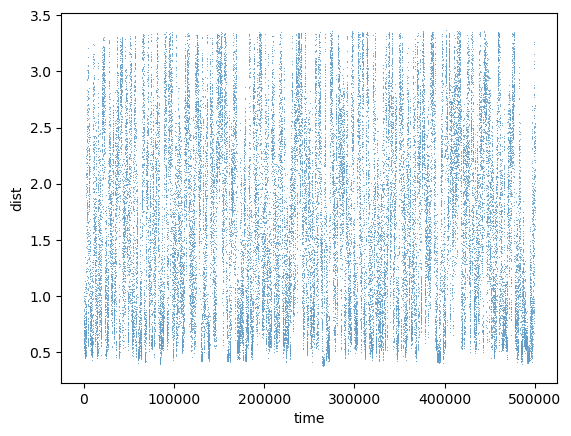

<Axes: xlabel='time', ylabel='height'>

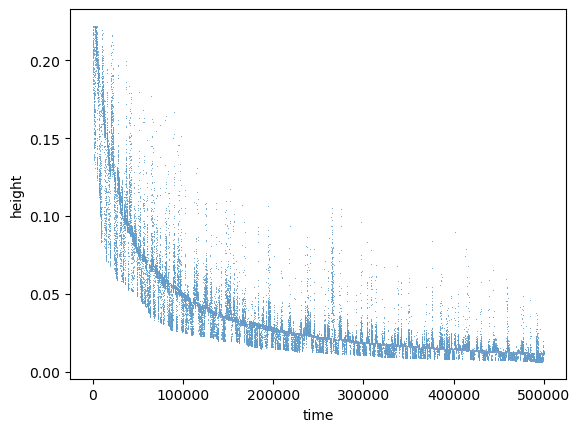

In [8]:
sns.scatterplot(CVs, x='time',y='dist',s=0.5)
plt.show()
sns.scatterplot(CVs, x='time',y='height',s=0.5)